In [2]:
import numpy as np
import pandas as pd
import gc
import warnings
import itertools
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from typing import *

import math
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

pd.options.display.max_rows = 200
pd.options.display.max_columns = 400

warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cpu")


In [18]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, inputs: int, outputs: int):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, outputs)

    def forward(self, x: torch.Tensor):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [42]:
def get_random_state(dim: int) -> torch.Tensor:
    return torch.from_numpy((np.random.rand(dim) > 0.5).astype(np.float32)).view(1, -1)


def get_fixed_reward(action: torch.Tensor) -> float:
    action_idx = action.item()
    if actions[action_idx] == "Hold":
        return -1
    else:
        return 1

### Training

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [32]:
actions = np.array(["Hold", "Go"])
n_actions = actions.shape[0]
state_dim = 10

policy_net = DQN(inputs=state_dim, outputs=n_actions).to(device)
target_net = DQN(inputs=state_dim, outputs=n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state: torch.Tensor) -> torch.Tensor:
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return select_fixed_action(state=state)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def select_fixed_action(state: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        return policy_net(state).max(1)[1].view(1, 1)

In [20]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), 
        device=device, 
        dtype=torch.bool
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [27]:
state = get_random_state(state_dim)
action = select_action(state)

In [43]:
episode_durations = []
num_episodes = 50
for i_episode in tqdm(range(num_episodes)):
    rewards = list()
    # Initialize the environment and state
    state = get_random_state(state_dim)
    for t in range(100):
        # Select and perform an action
        action = select_action(state)
        reward = get_fixed_reward(action)
        rewards.append(reward)
        reward = torch.tensor([reward], device=device)

        # Observe new state
        next_state = get_random_state(state_dim)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
    
    episode_durations.append(np.mean(rewards))

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.71it/s]


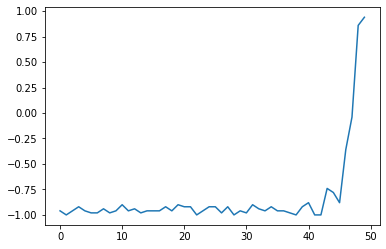

In [44]:
plt.plot(episode_durations)

In [46]:
rewards = list()
for t in range(100):
    # Select and perform an action
    action = select_fixed_action(state)
    reward = get_fixed_reward(action)
    rewards.append(reward)
    reward = torch.tensor([reward], device=device)

    # Observe new state
    next_state = get_random_state(state_dim)

    # Store the transition in memory
    memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state

print(f"Reward(fixed): {np.mean(rewards)}")

Reward(fixed): 1.0
